# Assimilation
## ICESat-2 Hackweek 2020
### Team Members: Debmita Bandyopadhyay, Friedrich Knuth, Tian Li, Mike Wood, Whyjay Zheng

In this project, we created a collection of simple tools to coregister DEMs with ATL06 data on bare ground.

---
## Step 0: Import the package

To begin, we import modules from our package `simlib` in `Assimilation`

In [1]:
import os
os.chdir('/home/jovyan/Assimilation/')

# Import packages
from pathlib import Path
from icepyx import icesat2data as ipd
import h5py
import numpy as np
import dask.dataframe as dd
import warnings
warnings.filterwarnings("ignore")

from simlib import atl06lib # subset and filter ATL06 data
from simlib.icesatapi import file_meta, OA_request  # request data from OpenAltimetry API
from simlib import coregistration as cor # DEM coregistration

Define data path

In [2]:
# Download folder 
data_home = Path('/home/jovyan/data/ATL06_RAW')

# Output folder
outdir = Path.home()/'data/ATL06_Processed'

# Create folder if it doesn't exist
data_home.mkdir(exist_ok=True)
outdir.mkdir(exist_ok=True)

---
## Step 1: Create a reference DEM object
In our `coregristration` module, we define a `reference_dem` class to hold information on the DEM to coregister with ICESat-2 points.

For this example, we consider a DEM of Mt. Baker in Washington State in the Continental US. We initiate a reference dem object using the coregistration module:

In [3]:
dem_file_path = '/home/jovyan/shared/data-knuth/reference_dem_clip.tif'
DEM = cor.reference_dem(dem_file_path)

The module contains the x and y coordinates (1-d arrays) of the DEM points, as well as the DEM itself. The module also contains a method to calculate the bounding box of the DEM:

In [4]:
print('x:','   min =',DEM.x.min(),'   max =',DEM.x.min(),'   shape = ',DEM.x.shape)
print('y:','   min =',DEM.y.min(),'   max =',DEM.y.min(),'   shape = ',DEM.y.shape)
print('dem:','   min =',DEM.dem.min(),'   max =',DEM.dem.min(),'   shape = ',DEM.dem.shape)
print('bbox:',DEM.bbox)
print('epsg:',DEM.epsg)

x:    min = 582482.8448944142    max = 582482.8448944142    shape =  (6599,)
y:    min = 5395092.518148141    max = 5395092.518148141    shape =  (8157,)
dem:    min = 909.614    max = 909.614    shape =  (8157, 6599)
bbox: [582482.8448944142, 5395092.518148141, 588510.3221990903, 5402543.276693823]
epsg: 32610


We can visualize this DEM using alongside a basemap for reference:

Text(0.5, 1.0, 'DEM')

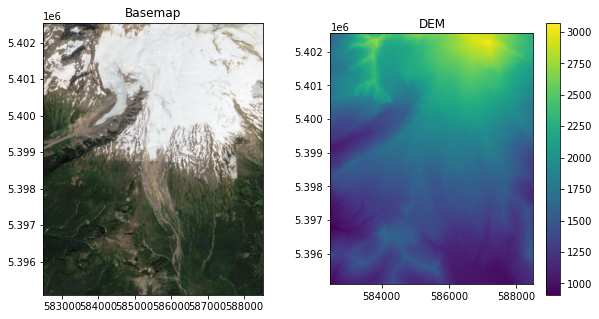

In [5]:
import matplotlib.pyplot as plt
import rasterio
import contextily as ctx

#create a spatial_extent tuple for matplotlib's imshow method
spatial_extent = (DEM.bbox[0],DEM.bbox[2],DEM.bbox[1],DEM.bbox[3]) #imshow uses a different ordering

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

#make a plot of the basemap for reference
url = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}'
ax1.imshow(DEM.dem, extent=spatial_extent)
ctx.add_basemap(ax1, crs='EPSG:32610', source=url)
ax1.set_title('Basemap')

#make a plot of the DEM
C = ax2.imshow(DEM.dem, extent=spatial_extent)
plt.colorbar(C)
ax2.set_title('DEM')


---
## Step 2: Locate ATL06 data in the DEM domain

To coregister the DEM with ATL06 data, next we query the ATL06 data set to find points with the DEM domain. We developed two methods for this query in our `atl06lib` module. In either case, the `atl06` library returns a `GeoDataFrame` which contains the ATL06 data in the coordinate reference system of the DEM:

#### ATL06 Query Method 1: Open Altimetry
**This method reads unfiltered data directly from OepnAltimtery into memory without actually downloading onto local disk. If you just want a quick look or simple manipulation of the elevation data in ROI**, this method can be the option. 
The returned parameters are:
* lat: latitude of segment
* lon: longitude of segment
* h: elevation
* beam: beam number
* cycle: ATL06 cycle number
* time: acquisiton date of data granule

In [6]:
# This section will show how the query is done via Open Altimetry
# atl06_overlap_gdf2 = is2.[function name to create the GeoData Frame with bbox input and method keyword]

# query datasets
short_name = 'ATL06'
date_range = ['2018-10-14','2020-04-04']

#Baker DEM
DEM.calculate_bounding_box(epsg=4326)
DEM_bbox = DEM.bbox
DEM_epsg = DEM.epsg

DEM_bboxq = [DEM_bbox[0].item(), DEM_bbox[1].item(), DEM_bbox[2].item(), DEM_bbox[3].item()]

region = ipd.Icesat2Data(short_name, DEM_bboxq, date_range)


#### Check parameters and visualization

product:     ATL06
dates:       ['2018-10-14', '2020-04-04']
start time:  00:00:00
end time:    23:59:59
version:     003
extent:      ['bounding box', [-121.87893182746436, 48.70258466806347, -121.79542720391288, 48.7704252035505]]

DATA:
('Number of available granules', 28)
('Average size of granules (MB)', 16.003927980146425)
('Total size of all granules (MB)', 448.1099834441)


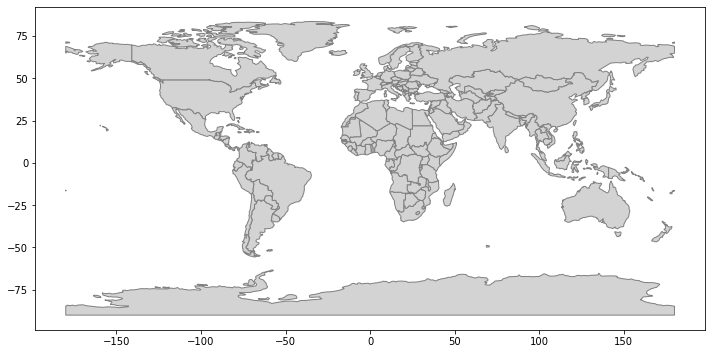

file list: ['ATL06_20181019231110_03260102_003_01.h5', 'ATL06_20181030110205_04860106_003_01.h5', 'ATL06_20181117214724_07680102_003_01.h5', 'ATL06_20181128093802_09280106_003_01.h5', 'ATL06_20181231080552_00440206_003_01.h5', 'ATL06_20190118185056_03260202_003_01.h5', 'ATL06_20190129064202_04860206_003_01.h5', 'ATL06_20190216172712_07680202_003_01.h5', 'ATL06_20190227051804_09280206_003_01.h5', 'ATL06_20190401034544_00440306_003_01.h5', 'ATL06_20190419143053_03260302_003_01.h5', 'ATL06_20190430022142_04860306_003_01.h5', 'ATL06_20190518130651_07680302_003_01.h5', 'ATL06_20190529005739_09280306_003_01.h5', 'ATL06_20190729220121_04860406_003_01.h5', 'ATL06_20190817084636_07680402_003_01.h5', 'ATL06_20190827203728_09280406_003_01.h5', 'ATL06_20190929190514_00440506_003_01.h5', 'ATL06_20191018055026_03260502_003_01.h5', 'ATL06_20191028174117_04860506_003_01.h5', 'ATL06_20191116042631_07680502_003_01.h5', 'ATL06_20191126161720_09280506_003_01.h5', 'ATL06_20191229144501_00440606_003_01.h5',

In [7]:
print('product:    ', region.dataset)
print('dates:      ', region.dates)
print('start time: ', region.start_time)
print('end time:   ', region.end_time)
print('version:    ', region.dataset_version)
print('extent:     ', region.spatial_extent)

#search for available granules and provide basic summary info about them
print('\nDATA:')
print('\n'.join([str(item) for item in region.avail_granules().items()]))

# visualize data extents
region.visualize_spatial_extent()

# Obtain ATL06 granule list
filelist = region.avail_granules(ids=True)
print ('file list:', filelist)

#### Send requests to the OpenAltimetry in parallel 

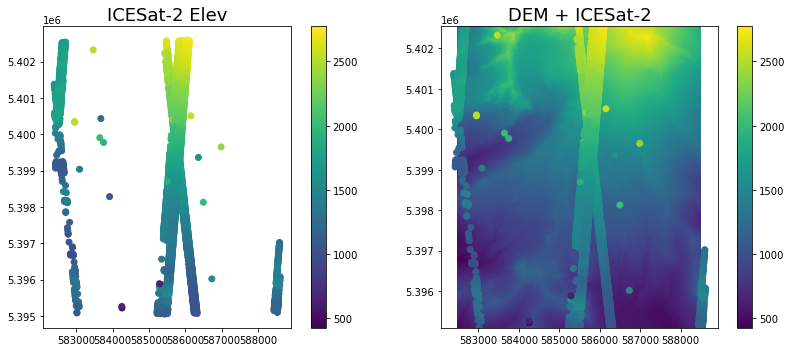

CPU times: user 7.6 s, sys: 640 ms, total: 8.24 s
Wall time: 7.43 s


In [8]:
%%time
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt 
from pyproj import CRS
from itertools import compress
import concurrent.futures
import rasterio
import rasterio.sample as rio_sample

para_lists = file_meta(filelist)

### Parallel processing ###
pool = concurrent.futures.ThreadPoolExecutor(max_workers=30)
parallel_data = {pool.submit(OA_request,paralist): paralist for paralist in para_lists}

results=[]
for future in concurrent.futures.as_completed(parallel_data):
    r = future.result()
    results.append(r)
    
ATL06_DATA = pd.concat(results) 

# convert into geodataframe
geometry = [Point(xy) for xy in zip(ATL06_DATA['lon'], ATL06_DATA['lat'])]        
gdf_OA = gpd.GeoDataFrame(ATL06_DATA, geometry=geometry, crs=CRS('EPSG:4326'))
gdf_OA = gdf_OA.to_crs({'init':'epsg:'+DEM_epsg})                
gdf_OA['x'], gdf_OA['y'] = gdf_OA['geometry'].x.tolist(), gdf_OA['geometry'].y.tolist()

# plot elevation
fig=plt.figure(figsize=(12, 5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

ax1.set_title('ICESat-2 Elev', fontsize=18)
ax2.set_title('DEM + ICESat-2', fontsize=18)

plt.tight_layout()
C2 = ax2.imshow(DEM.dem, extent=spatial_extent)
gdf_OA.plot(column='h', ax=ax1, legend=True, cmap='viridis')
gdf_OA.plot(column='h', ax=ax2, legend=True, cmap='viridis')
plt.show()

#### Filter ICESat-2 elevation anomalies based on DEM
From the above figure, we can see there exist many elevation anomalies in ICESat-2 ATL06 data compared with DEM. The parameters returned from OpenAltimetry API don't include any data quality flag for us to perform quality check, however, we can still set a threshold for elevation changes bewteen ICESat-2 ATL06 and DEM to perform a simple data filtering.

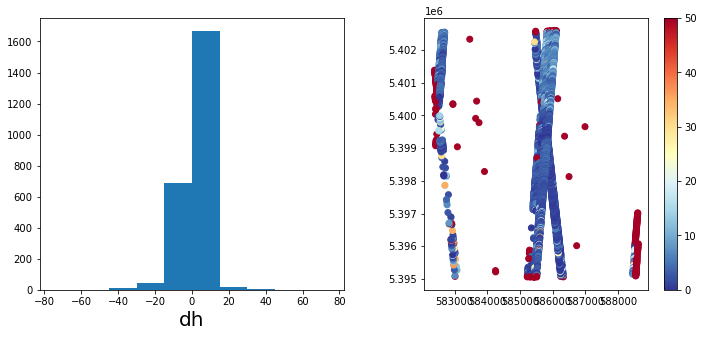

In [9]:
# basic data filtering based on DEM elevation
rio_ds = rasterio.open(dem_file_path)
ddf_xytuple = list(gdf_OA[['x', 'y']].to_records(index=False))

sample_gen = rio_ds.sample(ddf_xytuple)
rasterddf_gpd = gpd.GeoDataFrame()

h_raster = [float(record) for record in sample_gen]

gdf_OA['dem_elev'] = h_raster # DEM elev
gdf_OA['diff_elev'] = gdf_OA['h'] - gdf_OA['dem_elev'] # elevation difference between ICESat-2 and DEM
gdf_OA['abs_diff_elev'] = gdf_OA['diff_elev'].abs() # absolute value

# plot elevation
fig=plt.figure(figsize=(12, 5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

ax1.hist(gdf_OA['diff_elev'],range=[-75, 75] )
ax1.set_xlabel('dh', fontsize=20)
gdf_OA.plot(column='abs_diff_elev', ax=ax2, legend=True, cmap='RdYlBu_r', vmin=0, vmax=50)

# remove ICESat-2 data with elevation difference larger than 50m
gdf_OA_final = gdf_OA[(gdf_OA['abs_diff_elev']<50)]

#### Plot elevation differnce and filtered elevation

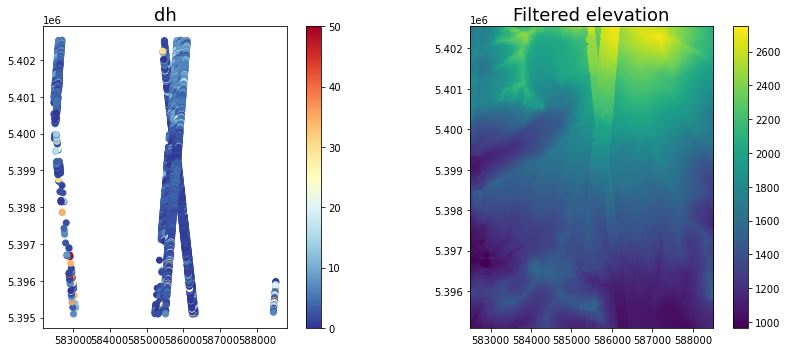

In [10]:
# plot elevation
fig=plt.figure(figsize=(12, 5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

ax1.set_title('dh', fontsize=18)
ax2.set_title('Filtered elevation', fontsize=18)
plt.tight_layout()

gdf_OA_final.plot(column='abs_diff_elev', ax=ax1, legend=True, cmap='RdYlBu_r', vmin=0, vmax=50)
C2 = ax2.imshow(DEM.dem, extent=spatial_extent)
gdf_OA_final.plot(column='h', ax=ax2, legend=True, cmap='viridis', marker='o')
plt.show()

#### ATL06 Query Method 2: `icepyx`

In [11]:
# This section will show how the query is done with icepyx
# atl06_overlap_gdf1 = is2.[function name to create the GeoData Frame with bbox input and method keyword]

# Earthdata Login user name and associated email
earthdata_uid = 'icetianli'
email = 'tian.li@bristol.ac.uk'

#### Download Data

In [12]:
# Only download if data folder is empty
if not list(data_home.glob('*.h5')):
    region.earthdata_login(earthdata_uid, email)
    region.order_granules(email=False)
    region.download_granules(data_home)

In [13]:
#Check downloaded data
files = list(data_home.glob('*.h5'))

for f in files[:10]: print(f)
print('Total number of files:', len(files))

/home/jovyan/data/ATL06_RAW/processed_ATL06_20190430022142_04860306_003_01.h5
/home/jovyan/data/ATL06_RAW/processed_ATL06_20190129064202_04860206_003_01.h5
/home/jovyan/data/ATL06_RAW/processed_ATL06_20181019231110_03260102_003_01.h5
/home/jovyan/data/ATL06_RAW/processed_ATL06_20190419143053_03260302_003_01.h5
/home/jovyan/data/ATL06_RAW/processed_ATL06_20190729220121_04860406_003_01.h5
/home/jovyan/data/ATL06_RAW/processed_ATL06_20190118185056_03260202_003_01.h5
Total number of files: 6


#### Reduce and filter ATL06 Data
To reduce and filter ATL06 elevation data, now we use read_atl06 function. It will firstly subset data based on bounding box obtained from the DEM and specific variables we want to use. Then it will use atl06_quality_summary quality flag, along-track segment difference and elevation threshold to filter elevation anomaly.

In [14]:
# Parallelization
njobs = 10 

if njobs == 1:
    print('running in serial ...')
    [atl06lib.read_atl06(f, DEM_epsg, outdir, DEM_bbox) for f in files]

else:
    print('running in parallel (%d jobs) ...' % njobs)
    from joblib import Parallel, delayed
    Parallel(n_jobs=njobs, verbose=5)(delayed(atl06lib.read_atl06)(f, DEM_epsg, outdir, DEM_bbox) for f in files)

running in parallel (10 jobs) ...


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of   6 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=10)]: Done   6 out of   6 | elapsed:    4.3s finished


In [15]:
# check reduced ATL06 files
outfiles = list(outdir.glob('*.h5'))

for f in outfiles[:10]: print(f)
print('Total number of files:', len(outfiles))

# check variable list
print('Variables:')
!h5ls -r {outfiles[0]}

/home/jovyan/data/ATL06_Processed/processed_ATL06_20190430022142_04860306_003_01_gt2r.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190129064202_04860206_003_01_gt3r.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190729220121_04860406_003_01_gt3l.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20181019231110_03260102_003_01_gt1l.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190129064202_04860206_003_01_gt3l.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190729220121_04860406_003_01_gt1l.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20181019231110_03260102_003_01_gt1r.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190729220121_04860406_003_01_gt3r.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190430022142_04860306_003_01_gt2l.h5
/home/jovyan/data/ATL06_Processed/processed_ATL06_20190430022142_04860306_003_01_gt3r.h5
Total number of files: 17
Variables:
/                        Group
/dac                     Dataset {46}
/dh_

### Plot data

Number of points (OpenAltimetry): 2436
Number of points (Icepyx): 894


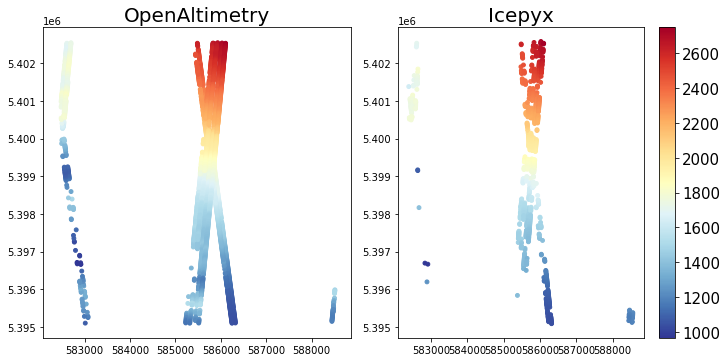

In [16]:
# Get list of files to plot
files = list(outdir.glob('*.h5'))

dfs = []
for f in files:
    f_data, vnames = atl06lib.read_h5(f)
    dd_data = dd.from_array(f_data, columns=vnames)
    dfs.append(dd_data)

# List with one dataframe per file
#dfs = [dd.from_array(atl06lib.read_h5(f), columns=vnames) for f in files] #

# Single parallel dataframe (larger than memory)
df = dd.concat(dfs)

# dask dataframe convert to pandas dataframe
df_nsidc = df.compute()

print('Number of points (OpenAltimetry):', len(gdf_OA_final))
print('Number of points (Icepyx):', len(df_nsidc))

# plot elevation
fig=plt.figure(figsize=(10, 5))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122, sharex=ax1, sharey=ax1)

cm = plt.cm.get_cmap('RdYlBu_r')
ax2.scatter(df_nsidc['x'], df_nsidc['y'], c=df_nsidc['h_li'], vmin=df_nsidc['h_li'].min(), vmax=df_nsidc['h_li'].max(), cmap=cm, s=15, label='Icepyx')
cs = ax1.scatter(gdf_OA_final['x'], gdf_OA_final['y'], c = gdf_OA_final['h'], vmin=gdf_OA_final['h'].min(), vmax=gdf_OA_final['h'].max(), cmap=cm, s=15, label='OpenAltimetry')

plt.tight_layout()
ax2.set_title('Icepyx', fontsize=20)
ax1.set_title('OpenAltimetry', fontsize=20)
colorbar = fig.colorbar(cs, ax=ax2)
colorbar.ax.tick_params(labelsize=15)
plt.show()

##### Comparison of methods

note to Tian/Friedrich: my idea for this section is to provide some comparison of the two methods, ideally ending with a side-by-side plot of the data in atl06_overlap_gdf1 and atl06_overlap_gdf2 over the basemap. what else would you like to add to this section?

---
## Step 3: Create a bare rock mask for the DEM

To coregister the DEM with the ATL06 data, we need to identify the points within the DEM domain which correspond to bare rock. For this analyis, we have created a method in the `reference_dem` class which generates the bare rock mask. There are three methods to obtain this mask:

#### Method 1: Mask non-ice areas using polygons in the RGI database

In [17]:
polygon_shapefile = '/home/jovyan/shared/data-whyjay/glims_mtBaker/glims_polygons.shp'
DEM.create_bare_rock_mask(method='RGI',polygon_shapefile=polygon_shapefile)
mask1 = DEM.mask

Creating mask with polygons from the Randolph Glacier Index (0=ice, 1=not ice)


#### Method 2: Mask with the NLCD dataset

In [18]:
# DEM.create_bare_rock_mask(method='NLCD')
# mask2 = DEM.mask

#### Method 3: Mask with snow thickness

In [19]:
# DEM.create_bare_rock_mask(method='CSNOW')
# mask3 = DEM.mask

Note to team: should we provide a side-by-side comparison of the masks in this section? What else ought to go in this section?

#### Mask method comparison

Text(0.5, 1.0, "Mask (method='RGI')")

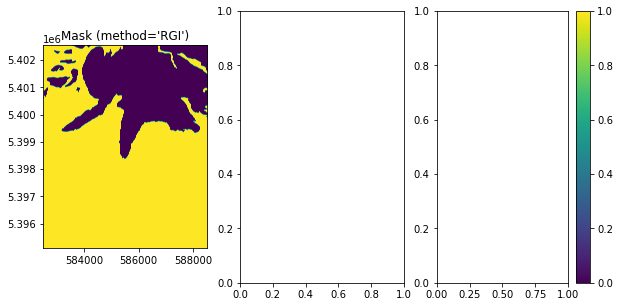

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(10,5))

C = ax1.imshow(DEM.mask, extent=spatial_extent)
plt.colorbar(C)
ax1.set_title('Mask (method=\'RGI\')')


---
## Step 4: Compare the DEM with ATL06 over bare rock

Note to team: in this section, we show how to use the `colocate_icesat2_dem_points` method to return the DEM vs ATL06 differences using GeoDataFrame provided by the `atl06lib` scripts. The mask can be incorporated here as a method to subset the points to bare ground

(5395092.518148141, 5402543.276693823)

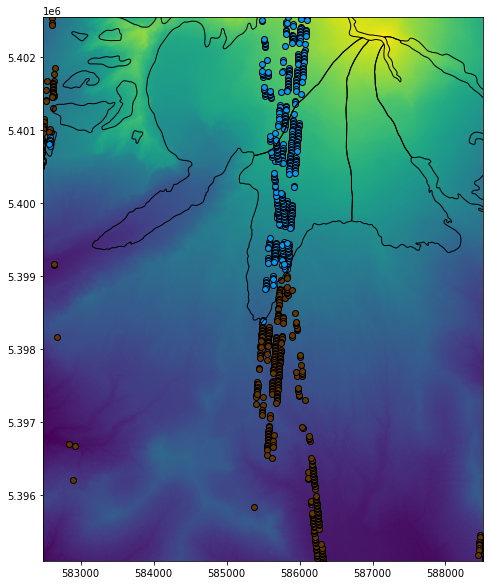

In [23]:
gdf_nsidc = gpd.GeoDataFrame(df_nsidc, geometry=gpd.points_from_xy(df_nsidc['x'], df_nsidc['y']), crs='EPSG:' + DEM.epsg)

glims_path = '/srv/shared/data-whyjay/glims_mtBaker/glims_polygons_EPSG32610.shp'
shapefile = gpd.read_file(glims_path)

idx = atl06lib.points_in_polygon(gdf_nsidc, glims_path)
gdf_nsidc['on_ice'] = idx
# print(is2_gpd)

fig,ax = plt.subplots(1,figsize=(10,10))
DEM.show(ax=ax)
gdf_nsidc[gdf_nsidc['on_ice'] == False].plot(ax=ax, facecolor='xkcd:brown', edgecolor='black')
gdf_nsidc[gdf_nsidc['on_ice'] == True].plot(ax=ax, facecolor='xkcd:azure', edgecolor='black')
# gdf_nsidc.plot(ax=ax, column='h_li', edgecolor='black')
shapefile.plot(ax=ax, facecolor="none", edgecolor='black')
ax.set_xlim([DEM.x.min(), DEM.x.max()])
ax.set_ylim([DEM.y.min(), DEM.y.max()])

Text(0.5, 0, 'dh (meters)')

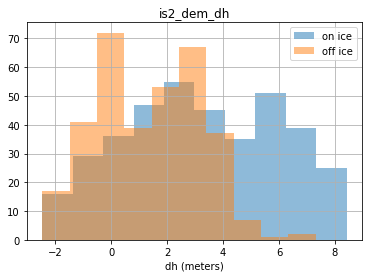

In [24]:
gdf_nsidc = DEM.Sample(gdf_nsidc)
gdf_nsidc['is2_dem_dh'] = gdf_nsidc['h_li'] - gdf_nsidc['h_dem']

# x.between(x.quantile(.15), x.quantile(.85))
goodpts_idx = gdf_nsidc['is2_dem_dh'].between(gdf_nsidc['is2_dem_dh'].quantile(.1), gdf_nsidc['is2_dem_dh'].quantile(.9))
# goodpts_idx = is2_gpd['is2_dem_dh'].between(-20, 20)
gdf_nsidc['is2_dem_dh'][goodpts_idx].describe()

gdf_nsidc_good = gdf_nsidc[goodpts_idx]
gdf_nsidc_good_onice  = gdf_nsidc_good[gdf_nsidc_good['on_ice'] == True]
gdf_nsidc_good_office = gdf_nsidc_good[gdf_nsidc_good['on_ice'] == False]
fix, ax = plt.subplots()
gdf_nsidc_good_onice.hist(column='is2_dem_dh', ax=ax, label='on ice', alpha=0.5)
gdf_nsidc_good_office.hist(column='is2_dem_dh', ax=ax, label='off ice', alpha=0.5)
ax.legend()
ax.set_xlabel('dh (meters)')

---
## Step 5: Preliminary Results

#### Preliminary Result 1: Pentration in snow/firm in radar-derived DEMs in High Mountain Asia

Note to team: do we have time to run this on a HMA example and check out the difference over ice after a height correction has been made to the DEM over bare ground?

#### Preliminary Result 2: Interpolation of ATL06 data

Note to Whyjay: do you want to add an interpolation result here?